# Download **JAFFE** Dataset

In [1]:
!./download_data.sh

--2016-02-13 20:36:05--  http://www.kasrl.org/jaffeimages.zip
Resolving www.kasrl.org (www.kasrl.org)... 69.89.22.142
Connecting to www.kasrl.org (www.kasrl.org)|69.89.22.142|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12239830 (12M) [application/zip]
Saving to: ‘jaffeimages.zip’

100%[======================================>] 12,239,830  9.06MB/s   in 1.3s   

2016-02-13 20:36:06 (9.06 MB/s) - ‘jaffeimages.zip’ saved [12239830/12239830]

Archive:  jaffeimages.zip
   creating: jaffe/
  inflating: jaffe/.DS_Store         
   creating: __MACOSX/
   creating: __MACOSX/jaffe/
  inflating: __MACOSX/jaffe/._.DS_Store  
  inflating: jaffe/KA.AN1.39.tiff    
  inflating: __MACOSX/jaffe/._KA.AN1.39.tiff  
  inflating: jaffe/KA.AN2.40.tiff    
  inflating: __MACOSX/jaffe/._KA.AN2.40.tiff  
  inflating: jaffe/KA.AN3.41.tiff    
  inflating: __MACOSX/jaffe/._KA.AN3.41.tiff  
  inflating: jaffe/KA.DI1.42.tiff    
  inflating: __MACOSX/jaffe/._KA.DI1.42.tiff  
  inflating

# PROBLEM a: (35 points)
In this problem, you will be dividing the images into blocks of sizes (16, 16), (32, 32), (64, 64) and performing principal component analysis in each case. For each case you will visualize reconstructions using different number of principal components and also visualize the top components.

Skeleton code for this problem has been provided in `hw1a.py` in the repository.



## Modules to be included

In [1]:
from os import walk
import numpy as np
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from PIL import Image

import theano
import theano.tensor as T
from theano.tensor.nnet.neighbours import images2neibs, neibs2images

Using gpu device 0: GRID K520


## Read Images
Read here all images(grayscale) from jaffe folder into an numpy array `Ims` with size `(no_images, height, width)`. Make sure the images are read after sorting the filenames.

In [2]:
file_names = []
for root, dirs, files in walk('jaffe/', topdown=True):
    for name in files:
        file_names.append(name)
file_names.sort()
Ims = np.zeros((len(file_names), 256, 256))
for i in range(len(file_names)):
    img = Image.open('jaffe/'+file_names[i])
    Ims[i, :, :] = np.asarray(img)

## Create `X`
Divide here each image into non-overlapping blocks of shape `(sz, sz)`. Flatten each block and arrange all the blocks in a `(no_images*n_blocks_in_image) x (sz*sz)` matrix called X

In [3]:
images = T.tensor4()
neibs = images2neibs(images, (16, 16))
divide = theano.function([images], neibs, allow_input_downcast=True)
X = divide(Ims.reshape((1, Ims.shape[0], Ims.shape[1], Ims.shape[2])))

## Standardize `X`

In [4]:
X_mn = np.mean(X, 0)
X = X - np.repeat(X_mn.reshape(1, -1), X.shape[0], 0)

Now each row in `X` represents a flattened image patch with original shape (16, 16). Note values of `X` are standardized along the columns.

In [5]:
X.shape

(54528, 256)

## Eigendecomposition
Perform eigendecomposition on `X^T X` and arrange the eigenvectors in decreasing order of eigenvalues into a matrix `D`

In [6]:
eigen_val, eigen_vec = np.linalg.eigh(np.dot(X.T, X))
D = np.fliplr(eigen_vec)
c = np.dot(D.T, X.T)

In [7]:
c.shape

(256, 54528)

## Plotting Functions

Plots nine PCA reconstructions of a particular image using number of components specified by num_coeffs

    Parameters
    ---------------
    c: np.ndarray
        a n x m matrix  representing the coefficients of all the image blocks.
        n represents the maximum dimension of the PCA space.
        m is (number of images x n_blocks**2)

    D: np.ndarray
        an N x n matrix representing the basis vectors of the PCA space
        N is the dimension of the original space (number of pixels in a block)

    im_num: Integer
        index of the image to visualize

    X_mn: np.ndarray
        a matrix representing the mean block.

    num_coeffs: Iterable
        an iterable with 9 elements representing the number_of coefficients
        to use for reconstruction for each of the 9 plots

    n_blocks: Integer
        number of blocks comprising the image in each direction.
        For example, for a 256x256 image divided into 64x64 blocks, n_blocks will be 4

In [14]:
def plot_mul(c, D, im_num, X_mn, num_coeffs, n_blocks):
    f, axarr = plt.subplots(3, 3)

    for i in range(3):
        for j in range(3):
            nc = num_coeffs[i*3+j]
            cij = c[:nc, n_blocks*n_blocks*im_num:n_blocks*n_blocks*(im_num+1)]
            Dij = D[:, :nc]
            plot(cij, Dij, n_blocks, X_mn, axarr[i, j])

    #f.savefig('output/hw1a_{0}_im{1}.png'.format(n_blocks, im_num))
    plt.show()
    #plt.close(f)

Plots a reconstruction of a particular image using D as the basis matrix and coeffiecient vectors from c

    Parameters
    ------------------------
        c: np.ndarray
            a l x m matrix  representing the coefficients of all blocks in a particular image
            l represents the dimension of the PCA space used for reconstruction
            m represents the number of blocks in an image

        D: np.ndarray
            an N x l matrix representing l basis vectors of the PCA space
            N is the dimension of the original space (number of pixels in a block)

        n_blocks: Integer
            number of blocks comprising the image in each direction.
            For example, for a 256x256 image divided into 64x64 blocks, n_blocks will be 4

        X_mn: basis vectors represent the divergence from the mean so this
            matrix should be added to all reconstructed blocks

        ax: the axis on which the image will be plotted

In [19]:
def plot(c, D, n_blocks, X_mn, ax):
    X = np.dot(D, c).T
    X = X + np.repeat(X_mn.reshape(1, -1), X.shape[0], 0)
    neib = T.matrix()
    image = neibs2images(neib, (int(256/n_blocks), int(256/n_blocks), (1, 1, 256, 256))[0, 0, :, :]
    reconstruct = theano.function([neib], image)
    img = reconstruct(X)
    plt.subplot(ax)
    plt.imshow(img, cmap='gray')

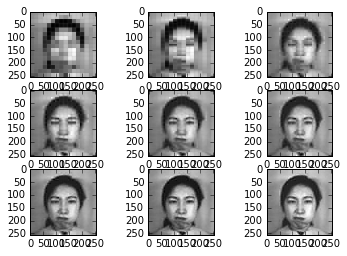

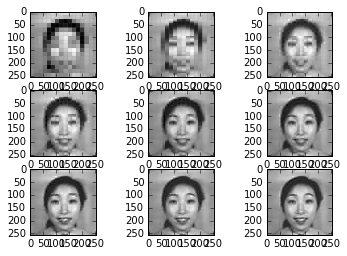

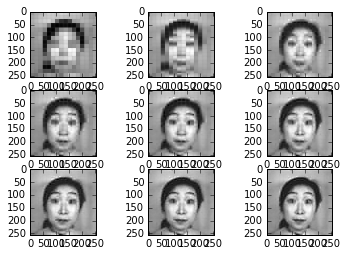

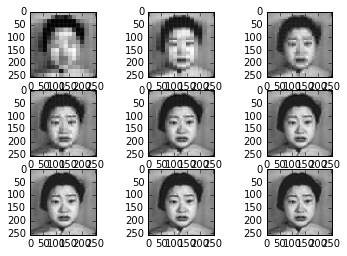

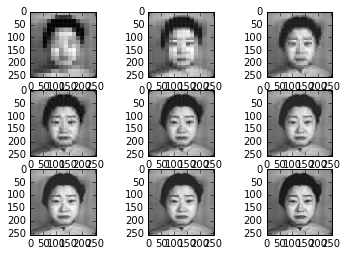

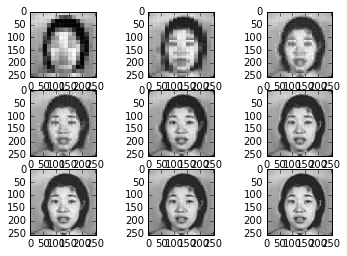

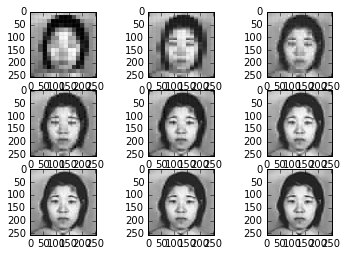

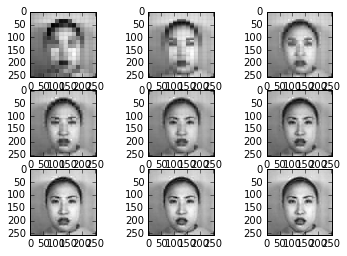

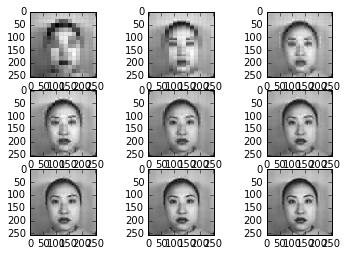

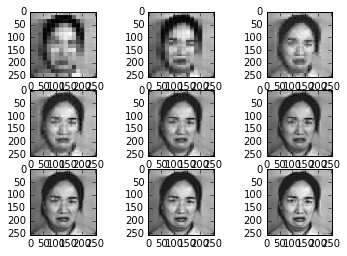

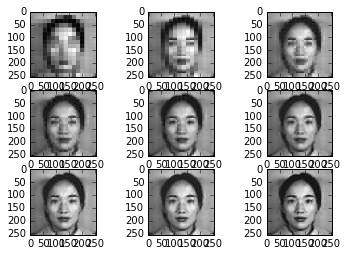

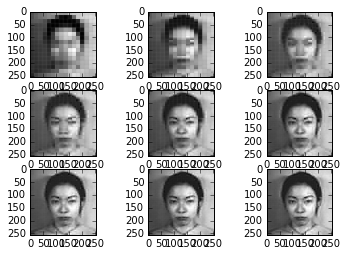

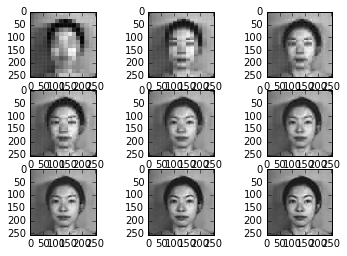

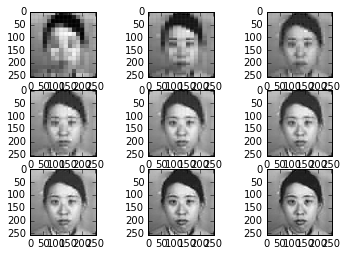

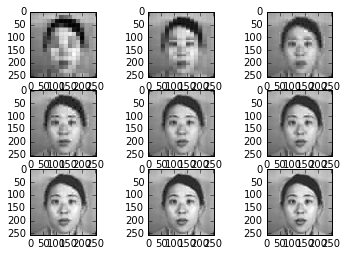

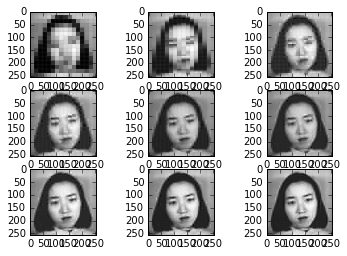

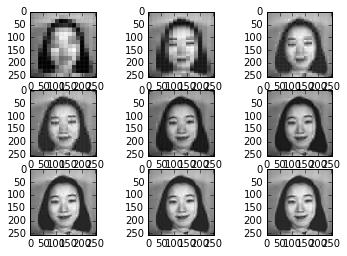

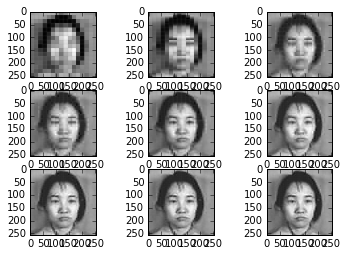

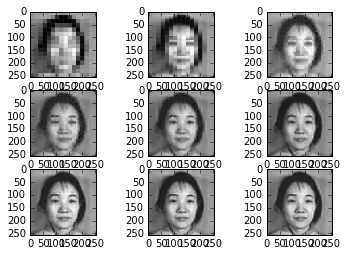

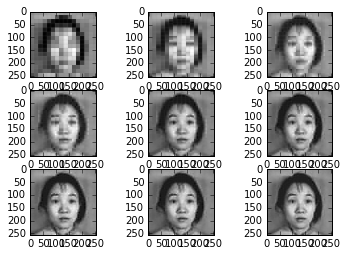

In [20]:
%matplotlib inline
for i in range(0, 200, 10):
    plot_mul(c, D, i, X_mn.reshape((16, 16)), num_coeffs=range(1, 10, 1), n_blocks=int(256/16))

Plots the top 16 components from the basis matrix D.
Each basis vector represents an image block of shape (sz, sz)

    Parameters
    -------------
    D: np.ndarray
        N x n matrix representing the basis vectors of the PCA space
        N is the dimension of the original space (number of pixels in a block)
        n represents the maximum dimension of the PCA space (assumed to be atleast 16)

    sz: Integer
        The height and width of each block

    imname: string
        name of file where image will be saved.

In [34]:
def plot_top_16(D, sz, imname):
    f, axarr = plt.subplots(4, 4)
    
    for i in range(4):
        for j in range(4):
            D_to_plot = np.reshape(D[:, (i*4+j)], (sz, sz))
            plt.subplot(axarr[i, j])
            plt.imshow(D_to_plot, cmap='gray')
            plt.axis('off')
    plt.show()
    f.savefig(imname)
    plt.close(f)

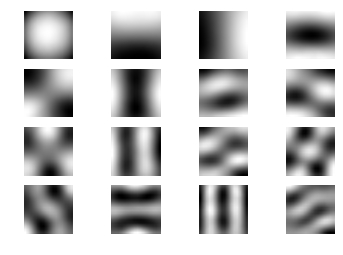

In [35]:
plot_top_16(D, 16, imname='output/hw1a_top16_{0}.png'.format(16))

## Final result

In [48]:
!python hw1a.py

Using gpu device 0: GRID K520
(54528, 256)
(256, 54528)
(256, 256)
(13632, 1024)
(1024, 13632)
(1024, 1024)
(3408, 4096)
(4096, 3408)
(4096, 4096)


# Problem b: (35 points)

Read all images(grayscale) from jaffe folder and collapse each image to get an numpy array Ims with size (no_images, height*width). Make sure to sort the filenames before reading the images

## Modules to Import

In [2]:
from os import walk
import numpy as np
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from PIL import Image

import theano
import theano.tensor as T

Using gpu device 0: GRID K520


## Load Images

In [3]:
file_names = []
for root, dirs, files in walk('jaffe/', topdown=True):
    for name in files:
        file_names.append(name)
file_names.sort()
I = np.zeros((len(file_names), 256*256))
for i in range(len(file_names)):
    img = Image.open('jaffe/'+file_names[i])
    I[i, :] = np.asarray(img).reshape((256*256,))

## Calculate `Ims` and `X`

In [4]:
Ims = I.astype(np.float32)
X_mn = np.mean(Ims, 0)
X_here = Ims - np.repeat(X_mn.reshape(1, -1), Ims.shape[0], 0)

In [5]:
X_here.shape

(213, 65536)

Use theano to perform gradient descent to get top 16 PCA components of X. Put them into a matrix D with decreasing order of eigenvalues

If you are not using the provided AMI and get an error "Cannot construct a ufunc with more than 32 operands" :
You need to perform a patch to theano from this pull(https://github.com/Theano/Theano/pull/3532)
Alternatively you can downgrade numpy to 1.9.3, scipy to 0.15.1, matplotlib to 1.4.2

## Theano Function Def

In [6]:
X = T.dmatrix()
D = T.dmatrix()
lambdas = T.dvector()
ita = 0.1
d = theano.shared(np.random.randn(65536))
x_term = T.dot(T.dot(X, d).T, T.dot(X, d))
d_term = T.dot(T.dot(D, d).T, T.dot(D, d)*lambdas)
gradient = T.grad(x_term-d_term, d)
y = d + ita * gradient
y_norm = T.sqrt(T.sum(T.sqr(y)))
loop_body = theano.function(inputs=[X, D, lambdas], 
                            updates=((d, (d + ita*gradient) / y_norm),)
                           )

## Loops of Calculation

In [26]:
lambdas_here, D_here = np.array([]), np.empty(shape=(0, 65536))
for i in range(16):
    for t in range(100):
        loop_body(X_here, D_here, lambdas_here)
        d_current = d.get_value()
        '''
        if len(D) >= 2:
            if np.abs(np.linalg.norm(D[-2]) - np.linalg.norm(D[-1])) < epsilon:
                break
        '''
    lambdas_here = np.append(lambdas_here, np.dot(np.dot(X_here, d_current).T, np.dot(X_here, d_current)))
    D_here = np.vstack((D_here, d_current))
    print d_current
    d.set_value(np.random.randn(65536))

[ 0.00539352  0.00544773  0.00543554 ...,  0.00118025  0.00122985
  0.00135014]
[-0.00160403 -0.00150183 -0.00141522 ..., -0.00048471 -0.00072432
 -0.00070317]
[ 0.0037348   0.00354443  0.00377444 ...,  0.0042128   0.00433508
  0.00429231]
[-0.00099779 -0.00087173 -0.00088202 ..., -0.00255058 -0.00224414
 -0.00215802]
[-0.00606745 -0.00609072 -0.00585089 ...,  0.00127517  0.00160109
  0.00165845]
[-0.00223849 -0.00247689 -0.00221351 ...,  0.00197159  0.00206863
  0.00213425]
[ 0.00232048  0.00227052  0.00215888 ..., -0.00566672 -0.00561665
 -0.00548058]
[ 0.00057801  0.00063931  0.00049072 ...,  0.00023255  0.00046668
  0.00012534]
[ 0.00220136  0.00170916  0.00151563 ..., -0.00167623 -0.00171458
 -0.00188592]
[ 0.00097588  0.0011067   0.00091658 ..., -0.00411258 -0.00434823
 -0.0042455 ]
[ 0.0033605   0.00341614  0.0029854  ...,  0.00329218  0.00333439
  0.0035616 ]
[-0.00201738 -0.00251909 -0.00135626 ...,  0.00162947  0.00141741
  0.00137945]
[ 0.0005011   0.00063924  0.00034829 ...

In [32]:
c_here = np.dot(D_here, X_here.T)

X_recons = np.dot(D_here.T, c_here).T

X_recons = X_recons + np.repeat(X_mn.reshape(1, -1), X_recons.shape[0], 0)

In [50]:
c_here.shape

(16, 213)

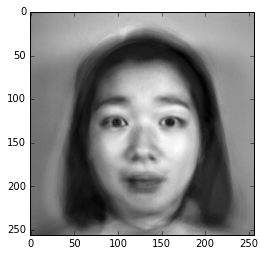

In [47]:
%matplotlib inline
test_img = X_recons[200].reshape((256, 256))
plt.imshow(test_img, cmap='gray')
plt.show()

Plots nine PCA reconstructions of a particular image using number of components specified by num_coeffs

    Parameters
    ---------------
    c: np.ndarray
        a n x m matrix  representing the coefficients of all the images
        n represents the maximum dimension of the PCA space.
        m represents the number of images

    D: np.ndarray
        an N x n matrix representing the basis vectors of the PCA space
        N is the dimension of the original space (number of pixels in the image)

    im_num: Integer
        index of the image to visualize

    X_mn: np.ndarray
        a matrix representing the mean image

In [51]:
def plot_mul(c, D, im_num, X_mn, num_coeffs):
    f, axarr = plt.subplots(3, 3)

    for i in range(3):
        for j in range(3):
            nc = num_coeffs[i*3+j]
            cij = c[:nc, im_num]
            Dij = D[:, :nc]
            plot(cij, Dij, X_mn, axarr[i, j])
    plt.show()
    #f.savefig('output/hw1b_im{0}.png'.format(im_num))
    plt.close(f)

Plots a reconstruction of a particular image using D as the basis matrix and c as the coefficient vector
    Parameters
    -------------------
        c: np.ndarray
            a l x 1 vector  representing the coefficients of the image.
            l represents the dimension of the PCA space used for reconstruction

        D: np.ndarray
            an N x l matrix representing first l basis vectors of the PCA space
            N is the dimension of the original space (number of pixels in the image)

        X_mn: basis vectors represent the divergence from the mean so this
            matrix should be added to the reconstructed image

        ax: the axis on which the image will be plotted

In [59]:
def plot(c, D, X_mn, ax):
    X = np.dot(D, c).T.reshape((256, 256))
    X = X + X_mn
    plt.subplot(ax)
    plt.imshow(X, cmap='gray')
    plt.axis('off')

## Test

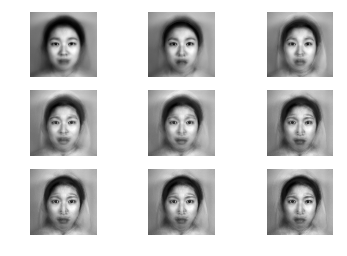

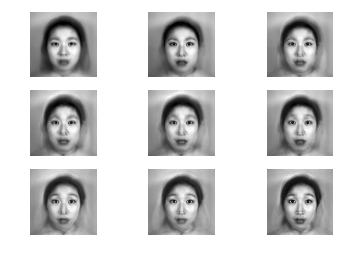

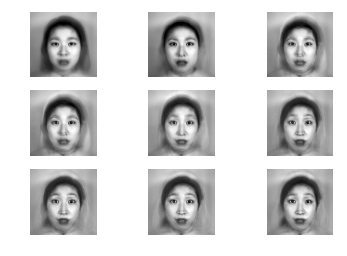

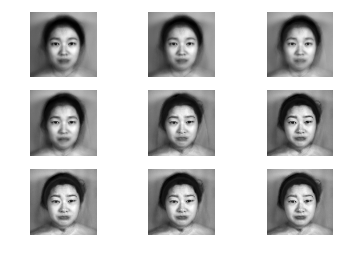

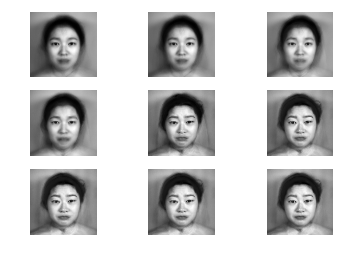

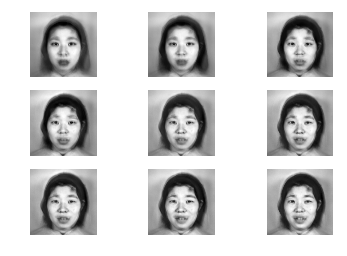

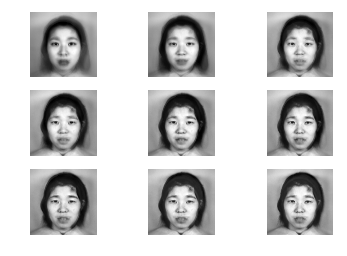

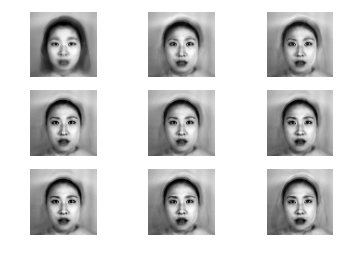

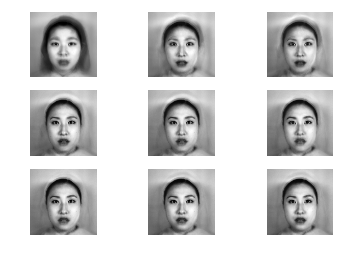

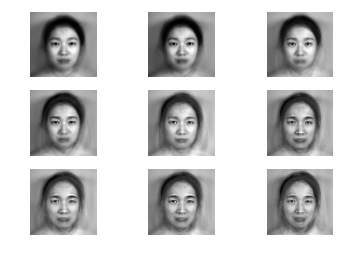

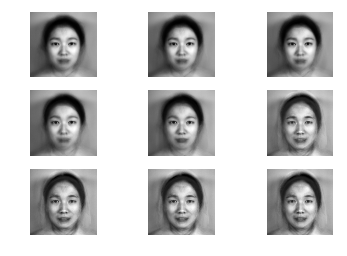

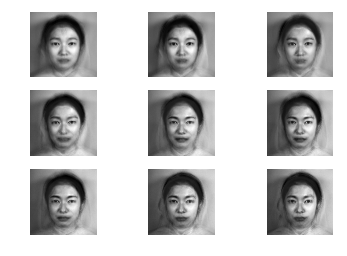

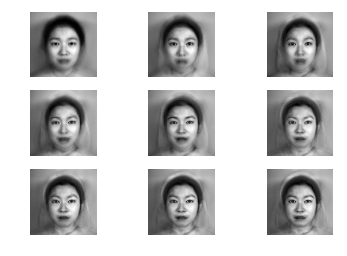

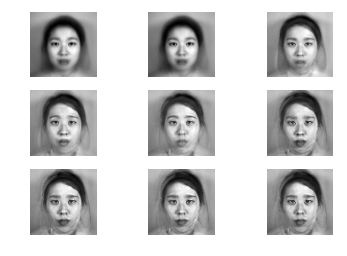

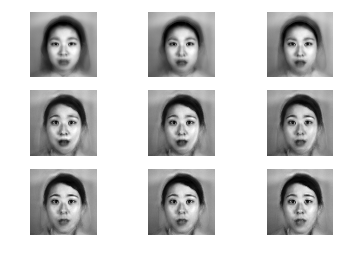

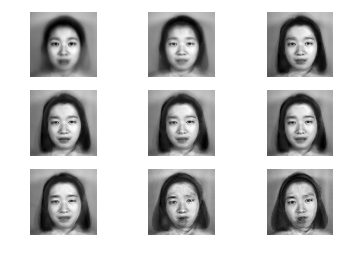

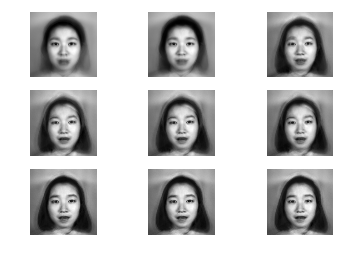

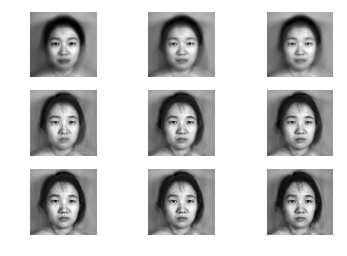

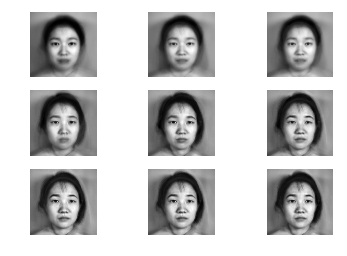

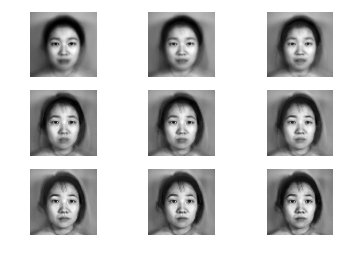

In [60]:
for i in range(0,200,10):
        plot_mul(c_here, D_here.T, i, X_mn.reshape((256, 256)),
                 [1, 2, 4, 6, 8, 10, 12, 14, 16])

Plots the top 16 components from the basis matrix D. Each basis vector represents an image of shape (sz, sz)

    Parameters
    -------------
    D: np.ndarray
        an N x n matrix representing the basis vectors of the PCA space
        N is the dimension of the original space (number of pixels in the image)
        n represents the maximum dimension of the PCA space (assumed to be atleast 16)

    sz: Integer
        The height and width of a image

    imname: string
        name of file where image will be saved.

In [54]:
def plot_top_16(D, sz, imname):
    f, axarr = plt.subplots(4, 4)
    
    for i in range(4):
        for j in range(4):
            D_to_plot = np.reshape(D[:, (i*4+j)], (sz, sz))
            plt.subplot(axarr[i, j])
            plt.imshow(D_to_plot, cmap='gray')
            plt.axis('off')
    plt.show()
    #f.savefig(imname)
    plt.close(f)

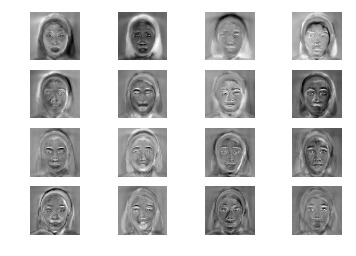

In [55]:
plot_top_16(D_here.T, 256, 'output/hw1b_top16_256.png')

In [58]:
D_here.min()

-0.028609203447654316

## Final Test

In [63]:
!python hw1b.py

Using gpu device 0: GRID K520
Principal component 0 found.
Principal component 1 found.
Principal component 2 found.
Principal component 3 found.
Principal component 4 found.
Principal component 5 found.
Principal component 6 found.
Principal component 7 found.
Principal component 8 found.
Principal component 9 found.
Principal component 10 found.
Principal component 11 found.
Principal component 12 found.
Principal component 13 found.
Principal component 14 found.
Principal component 15 found.
